# IRASA

This notebook measures aperiodic activity using the 'irregular resampling auto-spectral analysis' (IRASA) algorithm.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_synaptic_current, sim_combined
from neurodsp.spectral import compute_spectrum
from neurodsp.aperiodic import compute_irasa, fit_irasa

from fooof.plts import plot_spectrum, plot_spectra

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_59184/1701562862.py:10: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof.plts import plot_spectrum, plot_spectra


In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))
from apm.run import run_sims

from apm.methods import irasa
from apm.methods.settings import IRASA_PARAMS
from apm.methods.settings import IR_F_RANGE as F_RANGE

from apm.plts import plot_lines
from apm.plts.settings import AP_COL, COMB_COL
from apm.sim.settings import FS, SIM_PARAMS_AP, SIM_PARAMS_COMB, EXPS, FREQS, POWERS, N_SIMS, EXP
from apm.sim.examples import SIG_AP, SIG_KN, SIG_OSC, SIG_COMB

## Settings

In [3]:
# Notebook settings
SAVE_FIG = False

In [4]:
# Check the IRASA settings
print(IRASA_PARAMS)

{'fs': 1000, 'f_range': (1, 50)}


### Example: Powerlaw Signal

In [5]:
# Calculate IRASA and fit exponent
freqs, psd_ap, psd_pe = compute_irasa(SIG_AP, **IRASA_PARAMS)
fit_off, fit_exp = fit_irasa(freqs, psd_ap)

In [6]:
# Compute the full power spectrum
freqs_full, psd_full = compute_spectrum(SIG_AP, FS, f_range=F_RANGE)

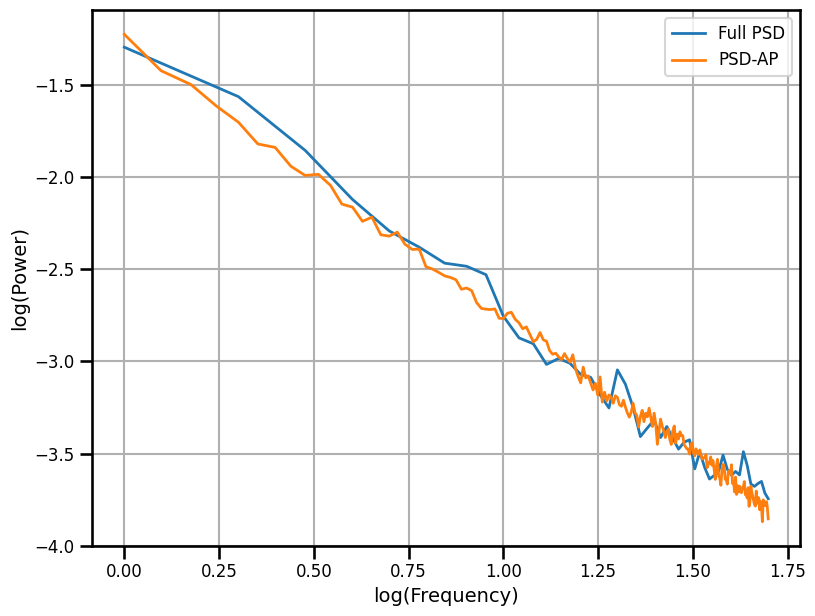

In [7]:
# Compare the full spectrum the IRASA separate aperiodic component
plot_spectra([freqs_full, freqs], [psd_full, psd_ap],
             labels=['Full PSD', 'PSD-AP'],
             log_freqs=True, log_powers=True)

In [8]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fit_exp))
print('Expected Exponent:\t {:1.4f}'.format(EXP))

Measured Exponent:	 -1.4856
Expected Exponent:	 -1.5000


### Example: Combined Signal

In [9]:
# Calculate IRASA and fit exponent
freqs, psd_ap, psd_pe = compute_irasa(SIG_COMB, **IRASA_PARAMS)
fit_off, fit_exp  = fit_irasa(freqs, psd_ap)

In [10]:
# Compute the full power spectrum
freqs_full, psd_full = compute_spectrum(SIG_COMB, FS, f_range=F_RANGE)

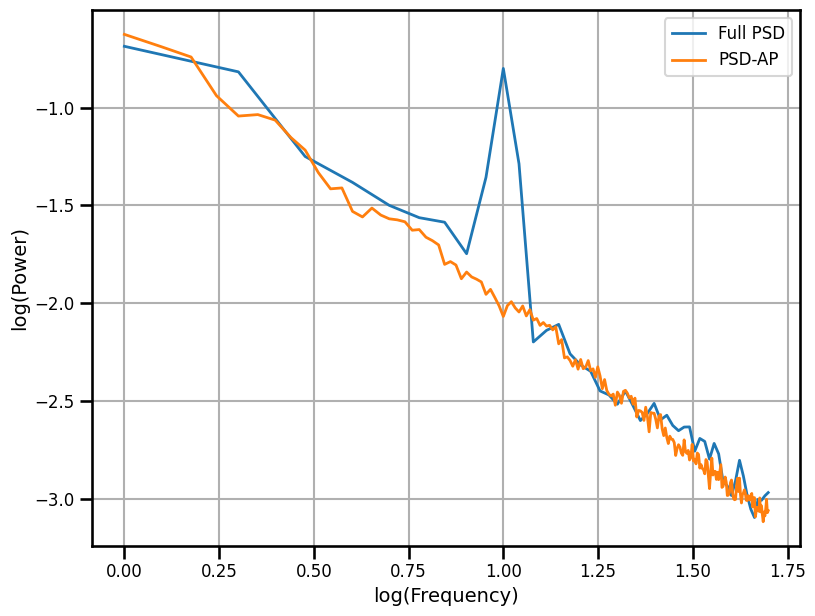

In [11]:
# Compare the full spectrum the IRASA separate aperiodic component
plot_spectra([freqs_full, freqs], [psd_full, psd_ap],
             labels=['Full PSD', 'PSD-AP'],
             log_freqs=True, log_powers=True)

In [12]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fit_exp))
print('Expected Exponent:\t {:1.4f}'.format(EXP))

Measured Exponent:	 -1.5146
Expected Exponent:	 -1.5000


### Example: Knee Signal

In [13]:
# Calculate IRASA and fit exponent
freqs, psd_ap, psd_pe = compute_irasa(SIG_KN, **IRASA_PARAMS)
fit_off, fit_exp  = fit_irasa(freqs, psd_ap)

In [14]:
# Compute the full power spectrum
freqs_full, psd_full = compute_spectrum(SIG_KN, FS, f_range=F_RANGE)

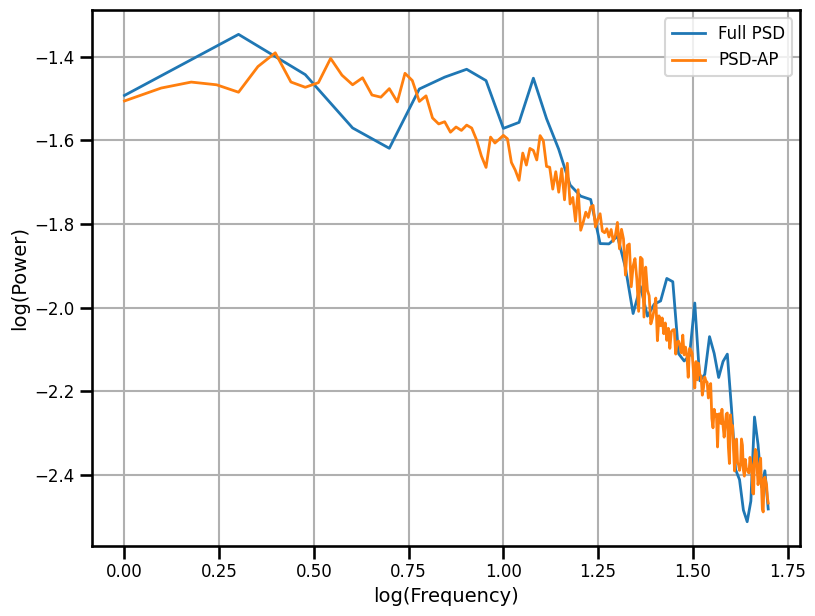

In [15]:
# Compare the full spectrum the IRASA separate aperiodic component
plot_spectra([freqs_full, freqs], [psd_full, psd_ap],
             labels=['Full PSD', 'PSD-AP'],
             log_freqs=True, log_powers=True)

In [16]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fit_exp))
print('Expected Exponent:\t {:1.4f}'.format(-2))

Measured Exponent:	 -0.8118
Expected Exponent:	 -2.0000


## IRASA Simulation Tests

### Powerlaw Signals - Across Exponents

In [17]:
# Run a set of simulations, calculating IRASA estimation across exponents
outs = run_sims(sim_powerlaw, SIM_PARAMS_AP, irasa, IRASA_PARAMS,
                'update_exp', EXPS, N_SIMS, var_func=np.std)
irasa_sims_exp, irasa_sims_exp_var = outs

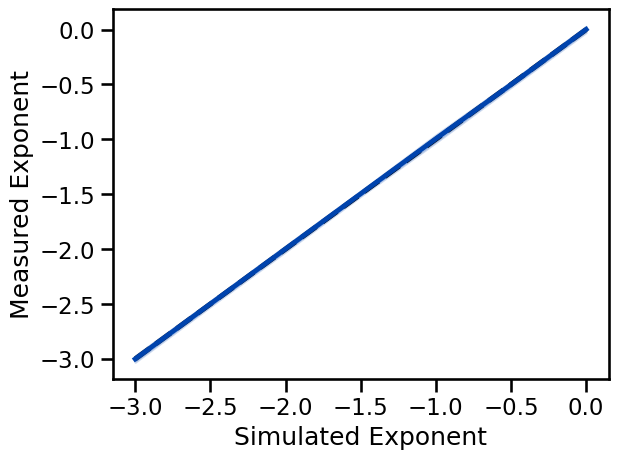

In [18]:
# Plot IRASA estimation across exponents
plot_lines(EXPS, EXPS, color='k', linestyle='--')
plot_lines(EXPS, irasa_sims_exp, irasa_sims_exp_var, color=AP_COL)
plot_lines(xlabel='Simulated Exponent', ylabel='Measured Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='irasa_exp', file_path='irasa')

### Powerlaw Signals with Oscillations - Across Exponents

In [19]:
# Run a set of simulations, calculating IRASA estimation across exponents
outs = run_sims(sim_combined, SIM_PARAMS_COMB, irasa, IRASA_PARAMS,
                'update_comb_exp', EXPS, N_SIMS, var_func=np.std)
irasa_sims_comb, irasa_sims_comb_var = outs

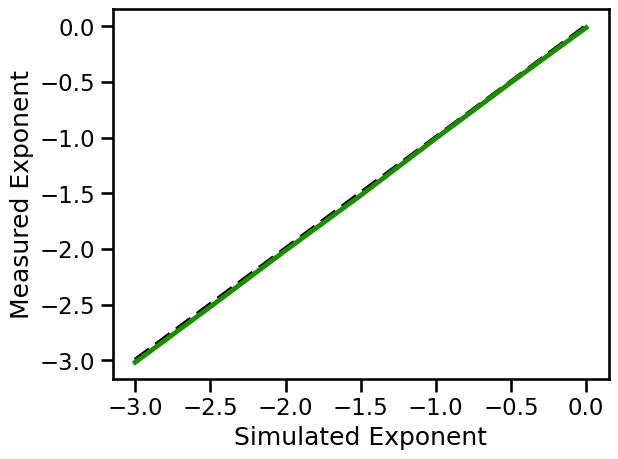

In [20]:
# Plot IRASA estimation across exponents, with an oscillation
plot_lines(EXPS, EXPS, color='k', linestyle='--')
plot_lines(EXPS, irasa_sims_comb, color=COMB_COL)
plot_lines(xlabel='Simulated Exponent', ylabel='Measured Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='irasa_comb', file_path='irasa')

### Plot Powerlaw with & without Oscillations

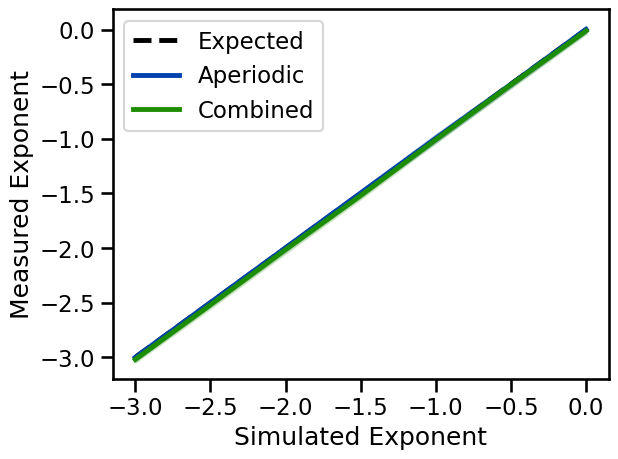

In [21]:
# Plot IRASA estimation across exponents, both with and without oscillation
plot_lines(EXPS, EXPS, color='k', linestyle='--', label='Expected')
plot_lines(EXPS, irasa_sims_exp, irasa_sims_exp_var, color=AP_COL, label='Aperiodic')
plot_lines(EXPS, irasa_sims_comb, irasa_sims_comb_var, color=COMB_COL, label='Combined')
plot_lines(xlabel='Simulated Exponent', ylabel='Measured Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='irasa_both', file_path='irasa')

### Powerlaw Signals with Oscillations - Across Oscillation Frequency

In [22]:
# Run a set of simulations, calculating IRASA across oscillation frequencies
outs = run_sims(sim_combined, SIM_PARAMS_COMB, irasa, IRASA_PARAMS,
                'update_freq', FREQS, N_SIMS, var_func=np.std)
irasa_sims_freq, irasa_sims_freq_var = outs

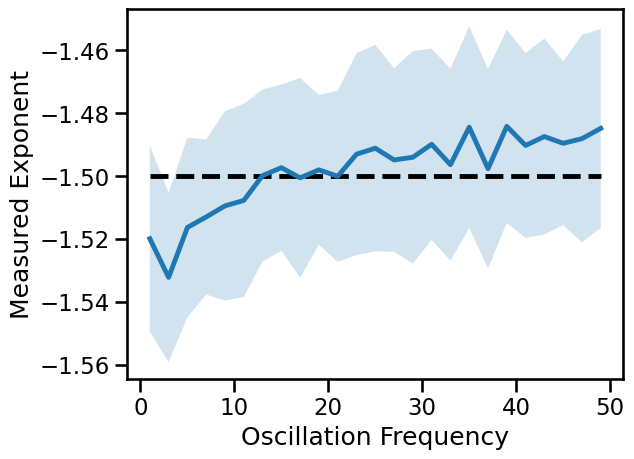

In [23]:
# Plot IRASA estimation across oscillation frequency values
plot_lines(FREQS, [EXP]*len(FREQS),  color='k', linestyle='--')
plot_lines(FREQS, irasa_sims_freq, irasa_sims_freq_var)
plot_lines(xlabel='Oscillation Frequency', ylabel='Measured Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='irasa_osc_freq', file_path='irasa')

### Powerlaw Signals with Oscillations - Across Oscillation Power

In [24]:
# Run a set of simulations, calculating IRASA across oscillation power
outs = run_sims(sim_combined, SIM_PARAMS_COMB, irasa, IRASA_PARAMS,
                'update_pow', POWERS, N_SIMS, var_func=np.std)
irasa_sims_pow, irasa_sims_pow_var = outs

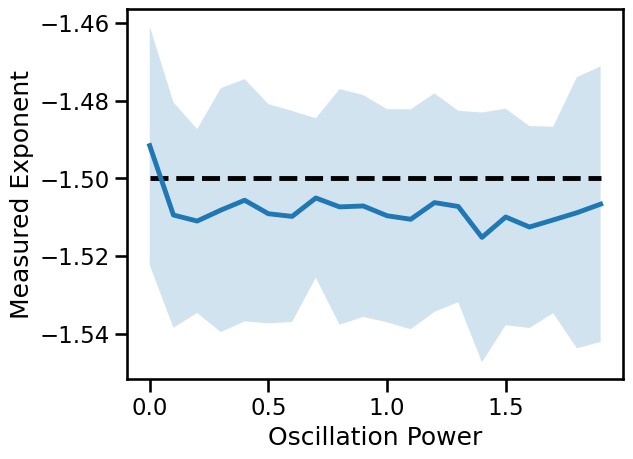

In [25]:
# Plot IRASA estimation across oscillation power values
plot_lines(POWERS, [EXP]*len(POWERS), color='k', linestyle='--')
plot_lines(POWERS, irasa_sims_pow, irasa_sims_pow_var)
plot_lines(xlabel='Oscillation Power', ylabel='Measured Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='irasa_osc_power', file_path='irasa')

## Conclusions

Overall, we can see the following patterns in these simulations:

IRASA:
- IRASA is highly accurate at estimating aperiodic exponent
- IRASA exponent estimations are generally not impacted by oscillation frequency or power